In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import ConfusionMatrixDisplay

import importlib
import sys
sys.path.append('./')
import NAB_scorer
importlib.reload(NAB_scorer)
from NAB_scorer import NABScorer

In [24]:
def plot_anomaly_scores(data, title, windows, threshold, labels):
    fig, ax1 = plt.subplots(figsize=(18, 6))
    # Ensure data.index is a pandas DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
        
    # Plot Oil Pressure and Pump Operation on the left y-axis
    ax1.plot(data.index, data['oil_pressure_u2'], label='Oil Pressure', color='b', alpha=0.8)
    ax1.plot(data.index, data['oil_pump_u2'].apply(lambda x: 100 if x == 1 else x), label='Pump Operation', color='g', linestyle='--', alpha=0.8)
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Value')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot Anomaly Score on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['anomaly_score'], label='Anomaly Score', color='r', linestyle='-.', alpha=0.8)
    ax2.axhline(y=threshold, color='purple', linestyle=':', label=f'Threshold ({threshold:.2f})')
    ax2.set_ylabel('Anomaly Score')
    ax2.legend(loc='upper right')

    # Highlight the anomaly windows
    for start, end in windows:
        ax1.axvspan(start, end, color='orange', alpha=0.3, label='Anomaly Window')
    
    # for label in labels:
    #     ax1.axvline(x=label, color='black', linestyle='-', alpha=0.7, label='Label')
        # y_label_points = data['y'].loc[labels]
        # ax1.plot(label, pd.to_datetime(y_label_points), 'bo', label='Label on Oil Pressure', alpha=0.8)

    # Plot label points as dots on data['y'] and data['z']
    
    # y_label_points = data['y'].loc[labels['pump_failure.csv']]
    # z_label_points = data['z'].loc[labels['pump_failure.csv']].apply(lambda x: 100 if x == 1 else x)
    # print(y_label_points, z_label_points)
    # ax1.plot(label, y_label_points, 'bo', label='Label on Oil Pressure', alpha=0.8)
    # ax1.plot(label, z_label_points, 'go', label='Label on Pump Operation', alpha=0.8)
    
    # Avoid duplicate legend entries for windows
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper left')

    plt.title(title)
    plt.show()

def plot_confusion_matrix(confusion_matrix, title="Confusion Matrix"):
    tp, tn, fp, fn = confusion_matrix['tp'], confusion_matrix['tn'], confusion_matrix['fp'], confusion_matrix['fn']
    cm = np.array([[tn, fp], [fn, tp]])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    plt.show()

# Example usage with the separate functions
def plot_all(score):
    plot_anomaly_scores(
        pump_failure, 
        'Pump Failure with Anomaly Score',
        windows=score['pump_failure.csv']['windows'], 
        threshold=score['pump_failure.csv']['threshold'],
        labels=label_dict['pump_failure.csv']
    )

    plot_confusion_matrix(
        score['pump_failure.csv']['confusion_matrix'], 
        title="Confusion Matrix for Pump Failure"
    )
    
    plot_anomaly_scores(
        inter_leakage, 
        'Inter Leakage with Anomaly Score',
        windows=score['inter_leakage.csv']['windows'], 
        threshold=score['inter_leakage.csv']['threshold'],
        labels=label_dict['inter_leakage.csv']
    )

    plot_confusion_matrix(
        score['inter_leakage.csv']['confusion_matrix'], 
        title="Confusion Matrix for Inter Leakage"
    )


windows: [(Timestamp('2024-04-01 06:25:00'), Timestamp('2024-04-02 01:50:00'))]
mean: 0.5032423424082682 std_dev: 0.3188458895523323
Threshold = 0.8255671118917691, normalized score = 98.17, score=0.975784057721728, (TP=289, TN=0, FP=81, FN=0)
Score for pump_failure.csv: 98.17 (threshold=0.8255671118917691)
windows: [(Timestamp('2024-04-01 06:25:00'), Timestamp('2024-04-01 08:55:00'))]
Threshold = 0.8323466490021791, normalized score = 97.30, score=0.9499590562661158, (TP=56, TN=0, FP=111, FN=0)
Score for inter_leakage.csv: 97.30 (threshold=0.8323466490021791)
98.17025291305121 97.3016429177678


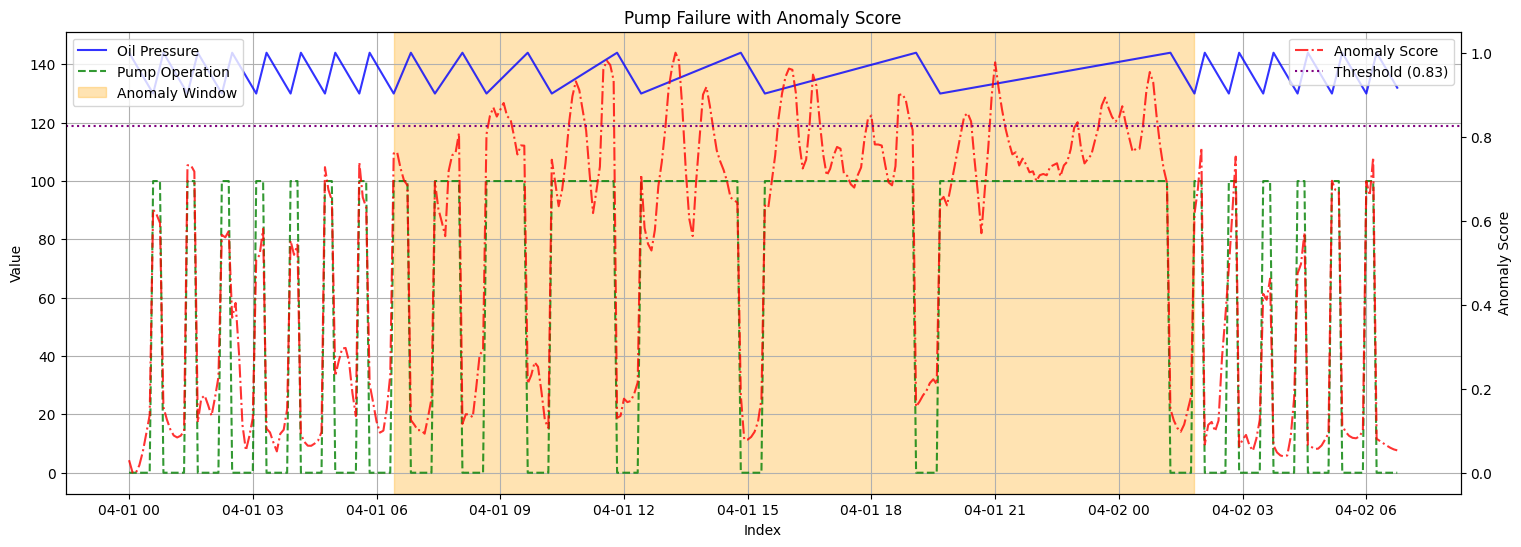

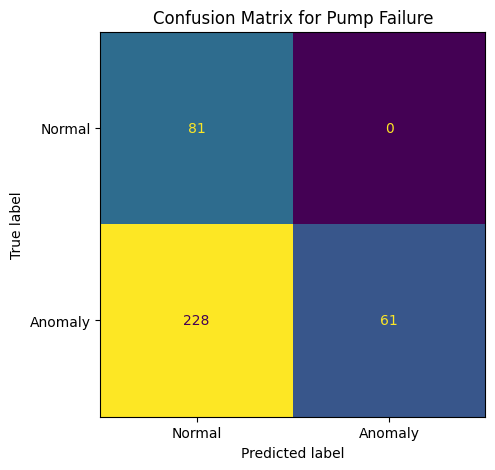

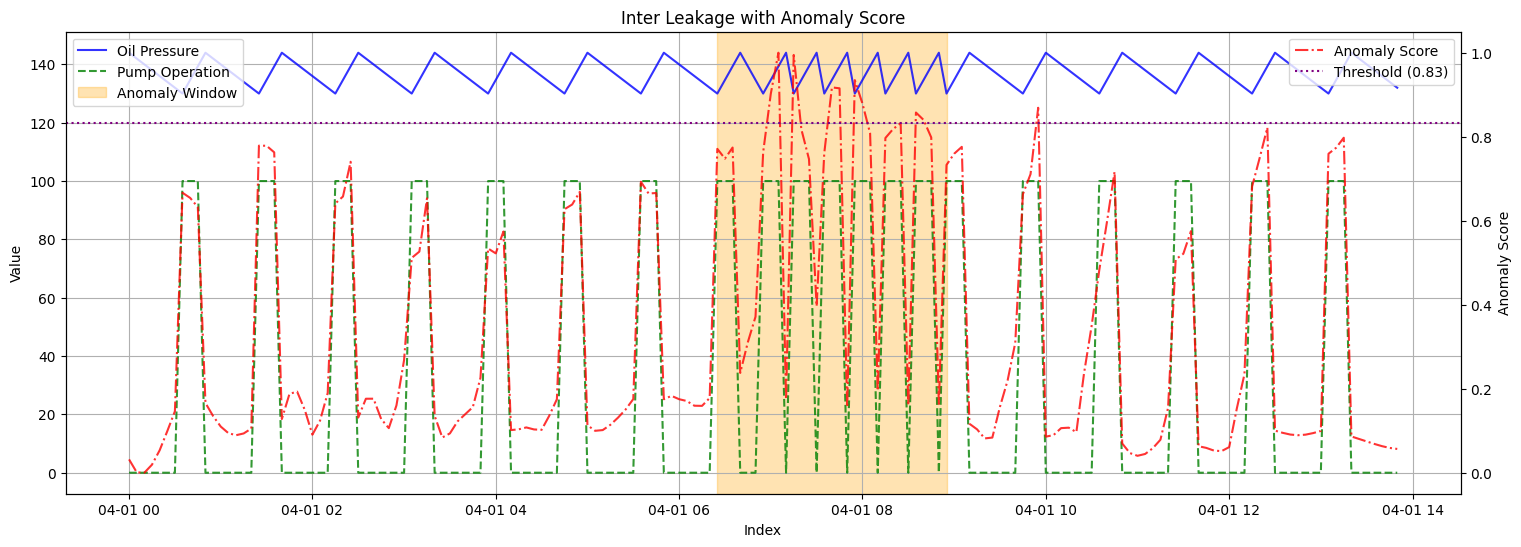

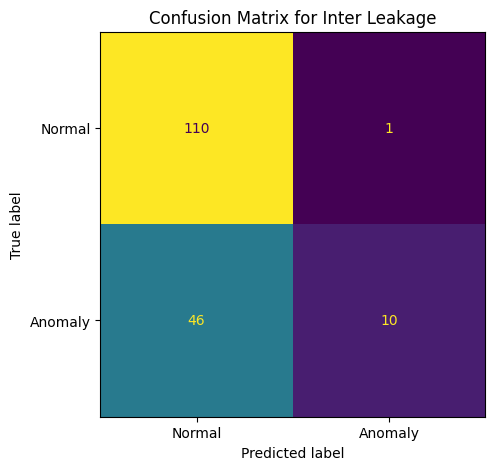

In [25]:
label_dict = json.load(open('./data/labels_window.json'))

inter_leakage = pd.read_csv('./results/inter_leakage_lstm_TL_u1_scored.csv', index_col='timestamp')
pump_failure = pd.read_csv('./results/pump_failure_lstm_TL_u1_scored.csv', index_col='timestamp')

data_dict = {
    "pump_failure.csv": pump_failure,
    "inter_leakage.csv": inter_leakage,
}

scorer = NABScorer(threshold='auto_cal')
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FN_rate')
print(score['pump_failure.csv']['score'], score['inter_leakage.csv']['score'])
plot_all(score)
score_u1 = score

windows: [(Timestamp('2024-04-01 06:25:00'), Timestamp('2024-04-02 01:50:00'))]
mean: 0.3514295253041893 std_dev: 0.3531568814112362
Threshold = 0.7165313629458948, normalized score = 98.26, score=0.9762899342696396, (TP=289, TN=0, FP=81, FN=0)
Score for pump_failure.csv: 98.26 (threshold=0.7165313629458948)
windows: [(Timestamp('2024-04-01 06:25:00'), Timestamp('2024-04-01 08:55:00'))]
Threshold = 0.7069447808176896, normalized score = 98.42, score=0.9651495666368277, (TP=56, TN=0, FP=111, FN=0)
Score for inter_leakage.csv: 98.42 (threshold=0.7069447808176896)
98.25571972663721 98.41988465164526


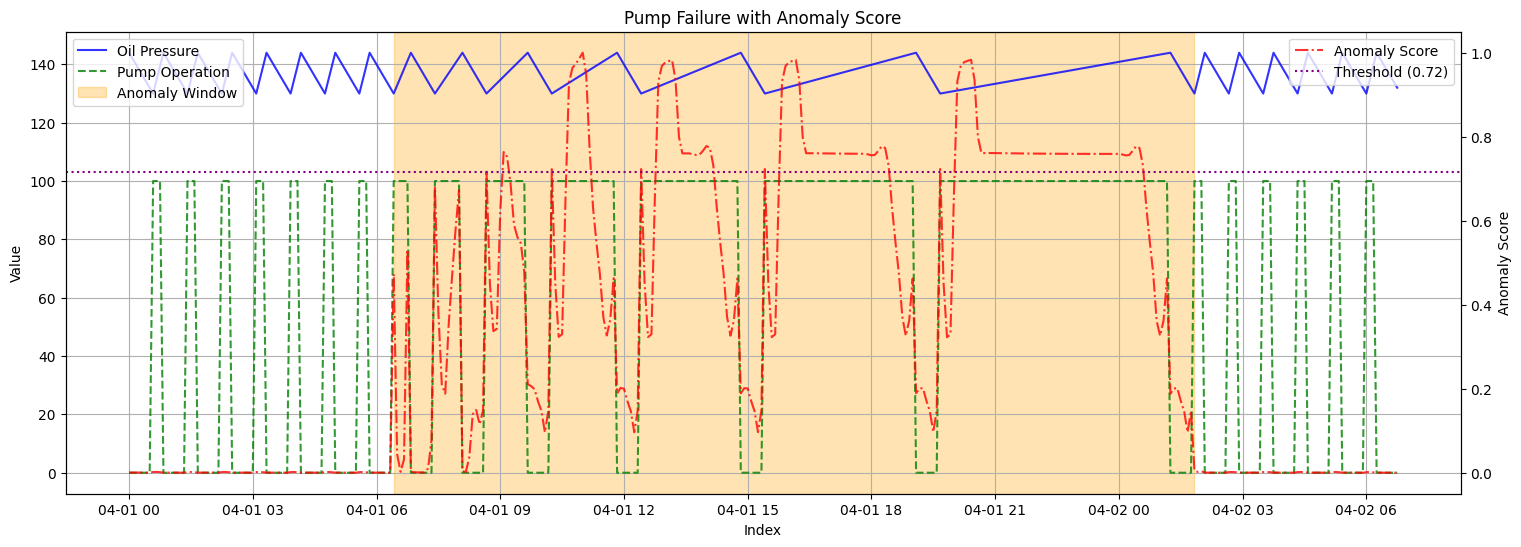

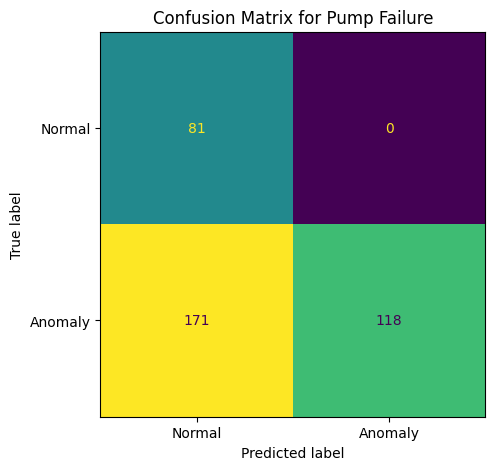

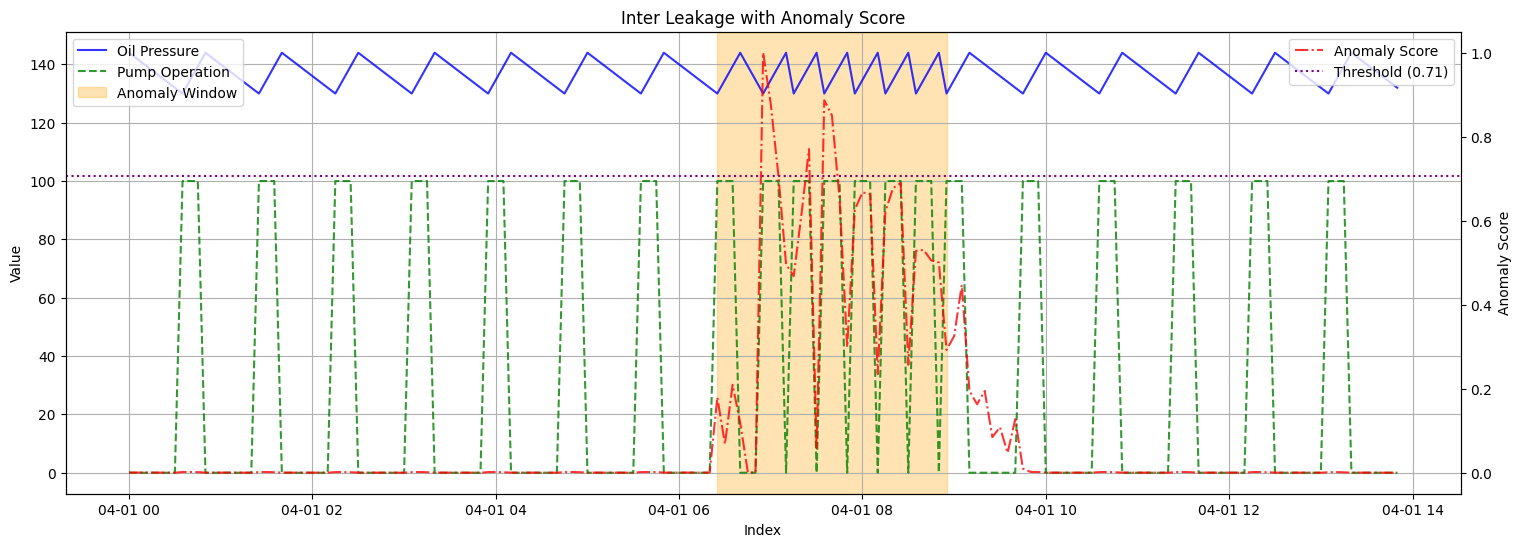

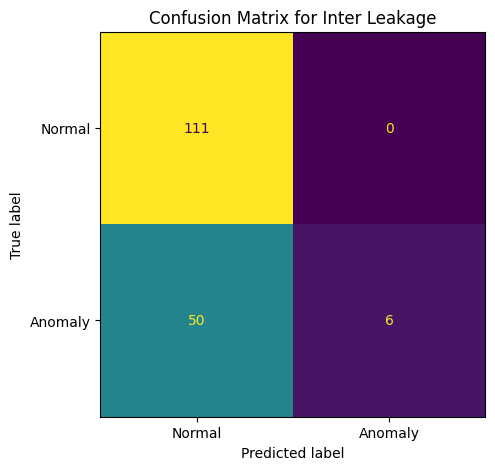

In [26]:
inter_leakage = pd.read_csv('./results/inter_leakage_lstm_TL_u2_scored.csv', index_col='timestamp')
pump_failure = pd.read_csv('./results/pump_failure_lstm_TL_u2_scored.csv', index_col='timestamp')

data_dict = {
    "pump_failure.csv": pump_failure,
    "inter_leakage.csv": inter_leakage,
}

scorer = NABScorer(threshold='auto_cal')
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FN_rate')
print(score['pump_failure.csv']['score'], score['inter_leakage.csv']['score'])
plot_all(score)
score_u2 = score

windows: [(Timestamp('2024-04-01 06:25:00'), Timestamp('2024-04-02 01:50:00'))]
mean: 0.3514295253041893 std_dev: 0.3531568814112362
Threshold = 0.7165313629458948, normalized score = 98.26, score=0.9762899342696396, (TP=289, TN=0, FP=81, FN=0)
Score for pump_failure.csv: 98.26 (threshold=0.7165313629458948)
windows: [(Timestamp('2024-04-01 06:25:00'), Timestamp('2024-04-01 08:55:00'))]
Threshold = 0.7069447808176896, normalized score = 98.42, score=0.9651495666368277, (TP=56, TN=0, FP=111, FN=0)
Score for inter_leakage.csv: 98.42 (threshold=0.7069447808176896)
98.25571972663721 98.41988465164526


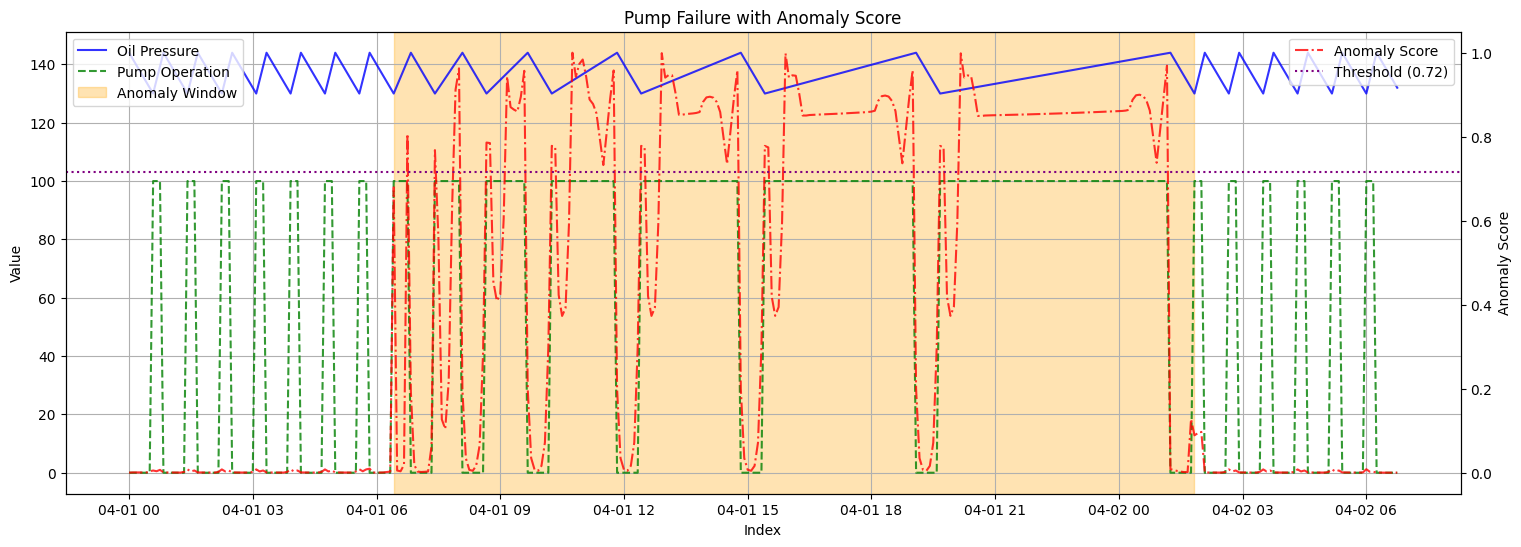

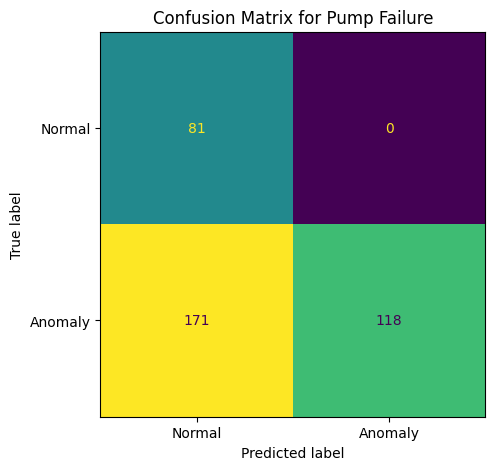

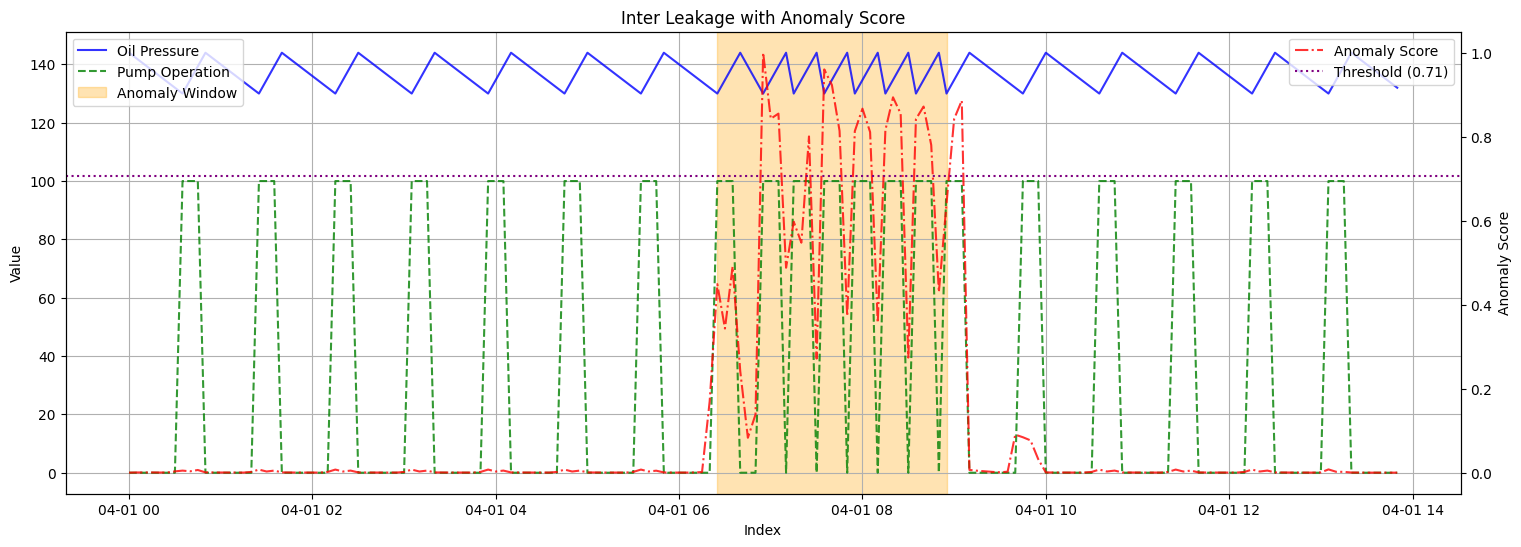

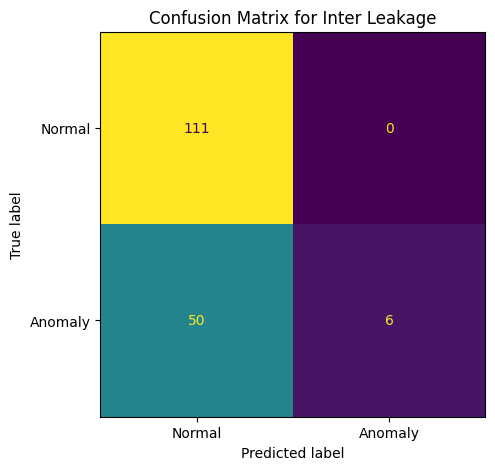

In [29]:
inter_leakage = pd.read_csv('./results/inter_leakage_lstm_small_scored.csv', index_col='timestamp')
pump_failure = pd.read_csv('./results/pump_failure_lstm_small_scored.csv', index_col='timestamp')
scorer = NABScorer(threshold='auto_cal')
score = scorer.score(data_dict, label_dict, label_windowed=True, profile='reward_low_FN_rate')
print(score['pump_failure.csv']['score'], score['inter_leakage.csv']['score'])
plot_all(score)
score_small = score

In [30]:
df_score = pd.DataFrame()
df_score.index = ['TL_u1', 'TL_u2', 'NoTL_small']
df_score['pump_failure'] = [score_u1['pump_failure.csv']['score'], score_u2['pump_failure.csv']['score'], score_small['pump_failure.csv']['score']]
df_score['inter_leakage'] = [score_u1['inter_leakage.csv']['score'], score_u2['inter_leakage.csv']['score'], score_small['inter_leakage.csv']['score']]
df_score

,pump_failure,inter_leakage
TL_u1,98.170253,97.301643
TL_u2,98.255720,98.419885
NoTL_small,98.255720,98.419885


In [ ]:
label_dict = json.load(open('../shf_labels.json'))

data_dict = {
    "pump_failure.csv": data1,
    "inter_leakage.csv": data2,
}

# Initialize scorer
scorer = NABScorer()

profiles = ["reward_low_FN_rate", "reward_low_FP_rate", "reward_low_FN_rate"]
scores = []

# Calculate scores
for p in profiles:
    scores.append(scorer.score(data_dict, label_dict, profile=p))
print('Final scores', scores)